# Предсказание направления цены - Биктоин - Временной интервал 1 день

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [ ]:
pip install cryptocompare

In [2]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.
beatrix

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
import requests
import IPython
import yaml
import json
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

In [3]:
api_key = 'b02ead34fa1fdb41fc47c9447ad211d4246b89678cd34467debc76d2832d3adf'

# Data Collection

Соберем три датасета: 1 - датасет с показателями цены и индикаторами, 2 - датасет с показателями блокчейна, 3 - датасет, показывающий распределение баланса криптовалюты между ее владельцами

In [4]:
# Number of past days for which we retrieve data
data_limit = 2000

# Define coin symbols
BTC = 'BTC'

# Generic function for an API call to a given URL
def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  # API call to cryptocompare
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

# OHLCV 

In [5]:
def prepare_pricedata(df):
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.index = df['date']
  df.drop(columns=['time', 'conversionType', 'conversionSymbol', 'date'], inplace=True)
  return df

# Load the price data
base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
df = api_call(f'{base_url}{BTC}&tsym=USD&limit={data_limit}')
OHLCV = prepare_pricedata(df)
OHLCV = OHLCV[:-1]
OHLCV

,high,low,open,volumefrom,volumeto,close
date,,,,,,
2017-12-02,11175.23,10715.55,10861.47,86825.51,9.504742e+08,10912.73
2017-12-03,11851.09,10578.43,10912.72,122125.70,1.380012e+09,11246.21
2017-12-04,11624.63,10917.81,11244.20,93173.90,1.057859e+09,11623.91
2017-12-05,11901.87,11486.13,11624.37,89687.21,1.048839e+09,11667.13
2017-12-06,13843.20,11661.76,11667.13,191576.66,2.437038e+09,13749.57
...,...,...,...,...,...,...
2023-05-20,27163.96,26839.84,26887.96,7364.81,1.987624e+08,27117.18
2023-05-21,27273.52,26691.13,27117.18,11953.22,3.222605e+08,26755.70
2023-05-22,27081.37,26547.27,26755.70,17663.14,4.737050e+08,26855.83


In [6]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2017-12-02 to 2023-05-24
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   high        2000 non-null   float64
 1   low         2000 non-null   float64
 2   open        2000 non-null   float64
 3   volumefrom  2000 non-null   float64
 4   volumeto    2000 non-null   float64
 5   close       2000 non-null   float64
dtypes: float64(6)
memory usage: 109.4 KB


In [7]:
OHLCV.describe()

,high,low,open,volumefrom,volumeto,close
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000
mean,21115.348935,19961.997840,20571.267615,56359.517565,1.017333e+09,20578.988385
std,16756.058156,15816.787427,16319.202255,43868.790701,9.794823e+08,16318.277026
min,3271.760000,3169.530000,3232.510000,7364.810000,5.672743e+07,3232.510000
25%,8244.437500,7797.682500,8054.540000,29298.070000,3.406278e+08,8054.540000
50%,12258.435000,11582.080000,11907.690000,43752.960000,7.223253e+08,11919.875000
75%,31330.697500,29478.397500,30407.255000,66883.387500,1.384330e+09,30407.255000
max,68978.640000,66312.420000,67549.140000,495883.240000,1.112022e+10,67549.140000


# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-часовая скользящая средняя

EMA_200 - 200-часовая скользящая экспоненциальная

SMA_50 - 50-часовая скользящая средняя

EMA_50 - 50-часовая скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26 дней для долгосрочной EMA и 12 дней для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [8]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [9]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [10]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

date
2017-12-16    80.029699
2017-12-17    77.952742
2017-12-18    76.813750
2017-12-19    69.382232
2017-12-20    59.627056
                ...    
2023-05-20    26.722530
2023-05-21    26.777328
2023-05-22    35.645374
2023-05-23    43.480005
2023-05-24    34.993336
Name: close, Length: 1986, dtype: float64

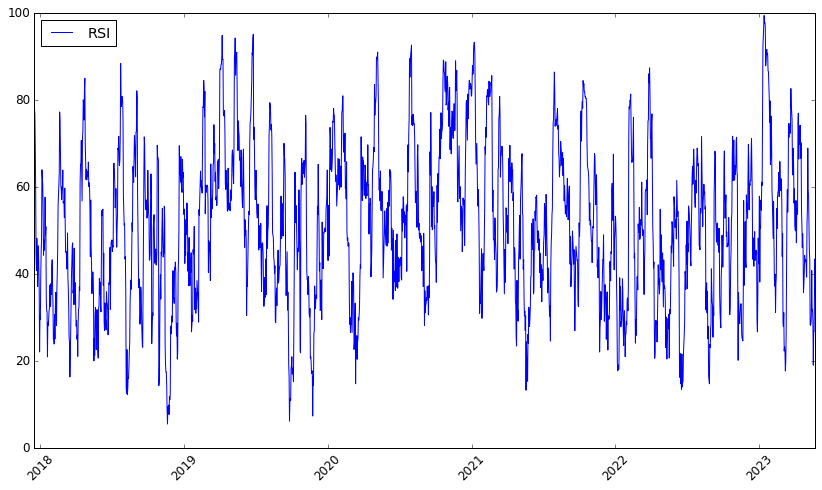

In [11]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

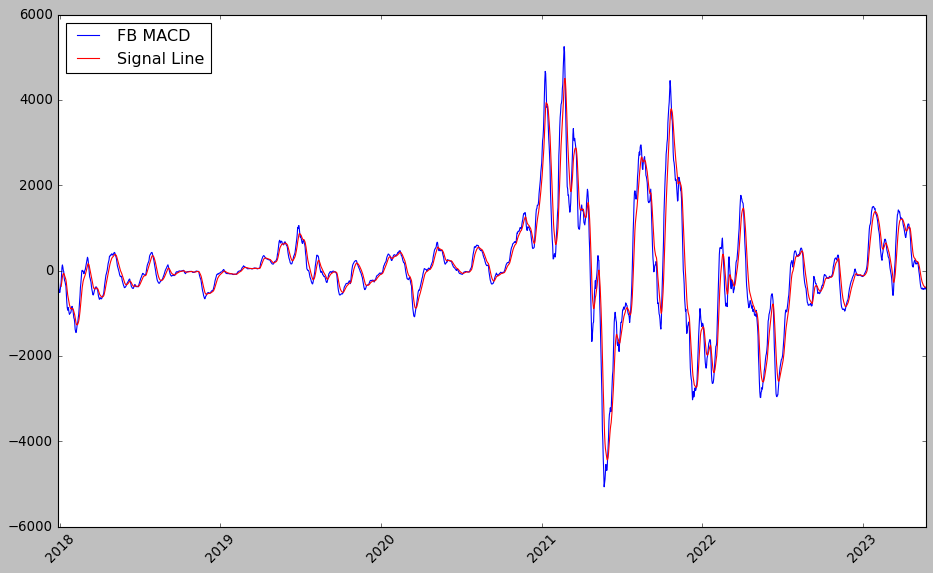

In [12]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [13]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [14]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [15]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,333.48,-137.12,51.25,675.86
1,377.70,339.38,331.48,-226.46
2,43.22,568.32,380.17,277.24
3,2082.44,175.63,42.76,1941.33
4,3100.74,1739.85,2082.96,3036.06
...,...,...,...,...
1994,229.22,178.37,66.11,-12.27
1995,-361.48,-148.71,229.22,109.56
1996,100.13,-143.86,-361.48,-192.15
1997,368.81,261.21,100.13,393.90


In [16]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [17]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [18]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [19]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  2000
SMA_200  ->  1801
EMA_200  ->  2000
SMA_50  ->  1951
EMA_50  ->  2000
RSI  ->  1986
macd  ->  1975
signal_line  ->  1967
histogram  ->  1967
close_diff  ->  1999
low_diff  ->  1999
open_diff  ->  1999
high_diff  ->  1999
width_open_close  ->  2000
width_open_high  ->  2000
width_open_low  ->  2000
color_of_candle  ->  2000
number_candle_trend  ->  2000


In [20]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles.index = OHLCV.index[-(len(SMA_200)):]
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
date,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,270.79,256.78,37.57,26.72,125.04,42.36,green,2.0
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,green,3.0
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,117.70,19.99,-27.82,-40.63,28.81,73.61,red,1.0
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,-746.34,-40.63,-58.57,-669.17,10.87,779.32,red,2.0
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,91.88,-669.17,-473.63,115.07,206.41,18.27,green,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,178.37,66.11,-12.27,229.22,276.00,48.12,green,2.0
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,-148.71,229.22,109.56,-361.48,156.34,426.05,red,1.0
2023-05-22,26855.83,22622.19660,24943.774852,28346.7192,27558.843373,35.645374,-427.134065,-383.874151,-43.259914,100.13,-143.86,-361.48,-192.15,100.13,325.67,208.43,green,1.0


In [21]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [22]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
date,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,270.79,256.78,37.57,26.72,125.04,42.36,green,2.0,6761.27
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,green,3.0,6720.64
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,117.70,19.99,-27.82,-40.63,28.81,73.61,red,1.0,6051.47
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,-746.34,-40.63,-58.57,-669.17,10.87,779.32,red,2.0,6166.54
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,91.88,-669.17,-473.63,115.07,206.41,18.27,green,1.0,6157.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,22522.74600,24883.933423,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,267.01,-582.50,-297.72,66.11,354.38,160.38,green,1.0,27117.18
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,178.37,66.11,-12.27,229.22,276.00,48.12,green,2.0,26755.70
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,-148.71,229.22,109.56,-361.48,156.34,426.05,red,1.0,26855.83


In [23]:
df_candles_supervised = df_candles.copy()
directions = []
for index, row in df_candles_supervised.iterrows():
    if row['close_next'] > row['close']:
        directions.append('long')
    else:
        directions.append('short')
df_candles_supervised['direction'] = directions
df_candles_supervised  

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next,direction
date,,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,270.79,256.78,37.57,26.72,125.04,42.36,green,2.0,6761.27,long
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,green,3.0,6720.64,short
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,117.70,19.99,-27.82,-40.63,28.81,73.61,red,1.0,6051.47,short
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,-746.34,-40.63,-58.57,-669.17,10.87,779.32,red,2.0,6166.54,long
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,91.88,-669.17,-473.63,115.07,206.41,18.27,green,1.0,6157.78,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,22522.74600,24883.933423,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,267.01,-582.50,-297.72,66.11,354.38,160.38,green,1.0,27117.18,long
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,178.37,66.11,-12.27,229.22,276.00,48.12,green,2.0,26755.70,short
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,-148.71,229.22,109.56,-361.48,156.34,426.05,red,1.0,26855.83,long


Кодируем категориальные переменнные

In [24]:


number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])
direction_encoder = LabelEncoder()
df_candles_supervised["direction"] = direction_encoder.fit_transform(df_candles_supervised["direction"])

df_candles_supervised.drop(columns = ['close_next'], inplace = True)

In [25]:
df_candles_supervised['direction'].value_counts()

0    924
1    876
Name: direction, dtype: int64

In [26]:
df_candles_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,direction
date,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,270.79,256.78,37.57,26.72,125.04,42.36,0,1,0
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,0,2,1
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,117.70,19.99,-27.82,-40.63,28.81,73.61,1,0,1
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,-746.34,-40.63,-58.57,-669.17,10.87,779.32,1,1,0
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,91.88,-669.17,-473.63,115.07,206.41,18.27,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,22522.74600,24883.933423,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,267.01,-582.50,-297.72,66.11,354.38,160.38,0,0,0
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,178.37,66.11,-12.27,229.22,276.00,48.12,0,1,1
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,-148.71,229.22,109.56,-361.48,156.34,426.05,1,0,0


Преобразованный датасет имеет 1800 строк и 19 колонок

# On chain 

In [27]:
# Query on-chain data

# Prepare the onchain dataframe
def prepare_onchain_data(df):
  # replace the timestamp with a data and filter some faulty values
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.index = df['date']
  df.drop(columns=['time','id','symbol', 'date'], inplace=True)
  df = df[df['hashrate'] > 0.0]
  return df
  
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
df = api_call(f'{base_url}{BTC}&limit={data_limit}')

# Filter some faulty values
onchain_df = prepare_onchain_data(df)
onchain_df

,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
date,,,,,,,,,,,,,,
2017-12-02,315512049,339109926,488452,965635,326354,277392487,31381,6.565847,497275,1.080032e+07,1.347001e+12,535.662500,1036298,1.671594e+07
2017-12-03,315974898,339649758,539832,1032301,353044,277745531,23273,5.298105,497451,1.177726e+07,1.347001e+12,491.228571,1047375,1.671814e+07
2017-12-04,316486668,340271118,621360,1154127,400686,278146217,40778,6.522200,497632,1.207401e+07,1.347001e+12,479.155556,1068300,1.672040e+07
2017-12-05,316981702,340908063,636945,1162235,405709,278551926,49488,7.433857,497810,1.211723e+07,1.347001e+12,477.446328,1058658,1.672263e+07
2017-12-06,317512869,341617732,709669,1243969,443587,278995513,67807,7.961259,497998,1.318919e+07,1.407975e+12,458.497326,1059046,1.672498e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20,1105241306,1151863519,361790,741142,423736,841070961,10488,1.153043,790660,3.340159e+08,4.954970e+13,637.138462,1709835,1.937913e+07
2023-05-21,1105602219,1152219350,355831,777170,486625,841557586,9550,1.093912,790811,3.727525e+08,4.954970e+13,570.926667,1849795,1.938008e+07
2023-05-22,1105966587,1152608872,389522,830833,499281,842056867,12944,1.676887,790955,3.532004e+08,4.954970e+13,602.531469,1707516,1.938097e+07


In [28]:
pd.date_range(start = onchain_df.index[0], end = onchain_df.index[-1] ).difference(onchain_df.index)

DatetimeIndex(['2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17'], dtype='datetime64[ns]', freq=None)

In [29]:
onchain_df = onchain_df.reindex(pd.date_range(start = onchain_df.index[0], end = onchain_df.index[-1] ))

In [30]:
columns = onchain_df.columns.values
for column in columns:
    onchain_df[column] = onchain_df[column].fillna(onchain_df[column].mean())

In [31]:
onchain_df = onchain_df[-len(df_candles_supervised) - 1:-1]
onchain_df

,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
2018-06-19,3.868683e+08,4.094810e+08,276495.0,630701.0,191805.0,323339844.0,7765.0,7.678289,528286.0,3.861409e+07,5.024546e+12,558.870130,908624.0,1.710356e+07
2018-06-20,3.871478e+08,4.097698e+08,288861.0,593528.0,198889.0,323538733.0,7319.0,5.824724,528441.0,3.966299e+07,5.077499e+12,549.824675,1078000.0,1.710550e+07
2018-06-21,3.874102e+08,4.100515e+08,281662.0,572851.0,198113.0,323736846.0,7615.0,4.666170,528611.0,4.295354e+07,5.077499e+12,507.704142,616743.0,1.710762e+07
2018-06-22,3.876892e+08,4.103364e+08,284873.0,628367.0,204144.0,323940990.0,8579.0,9.143919,528762.0,3.826090e+07,5.077499e+12,569.973333,795271.0,1.710951e+07
2018-06-23,3.878991e+08,4.105716e+08,235258.0,490606.0,163295.0,324104285.0,5685.0,8.762188,528922.0,4.110610e+07,5.077499e+12,530.522013,534422.0,1.711151e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,1.104947e+09,1.151502e+09,437346.0,898269.0,515474.0,840647225.0,13879.0,1.419288,790529.0,3.741912e+08,4.954970e+13,568.731544,1726897.0,1.937913e+07
2023-05-20,1.105241e+09,1.151864e+09,361790.0,741142.0,423736.0,841070961.0,10488.0,1.153043,790660.0,3.340159e+08,4.954970e+13,637.138462,1709835.0,1.937913e+07
2023-05-21,1.105602e+09,1.152219e+09,355831.0,777170.0,486625.0,841557586.0,9550.0,1.093912,790811.0,3.727525e+08,4.954970e+13,570.926667,1849795.0,1.938008e+07
2023-05-22,1.105967e+09,1.152609e+09,389522.0,830833.0,499281.0,842056867.0,12944.0,1.676887,790955.0,3.532004e+08,4.954970e+13,602.531469,1707516.0,1.938097e+07


# Balance Distribution

In [32]:
# Prepare balance distribution dataframe
def prepare_balancedistribution_data(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
df_raw = api_call(f'{base_url}{BTC}&limit={data_limit}')
df_distr = prepare_balancedistribution_data(df_raw)
df_distr

,date,totalVolume,addressesCount,range
0,2017-12-02,2.367251e+03,13337046.0,0.0_to_0.001
1,2017-12-02,1.780287e+04,4399165.0,0.001_to_0.01
2,2017-12-02,1.131168e+05,3596997.0,0.01_to_0.1
3,2017-12-02,5.079844e+05,1579596.0,0.1_to_1.0
4,2017-12-02,1.425499e+06,531547.0,1.0_to_10.0
...,...,...,...,...
19994,2023-05-24,2.106398e+06,844470.0,1.0_to_10.0
19995,2023-05-24,4.441584e+06,140210.0,10.0_to_100.0
19996,2023-05-24,3.886943e+06,13835.0,100.0_to_1000.0
19997,2023-05-24,4.619782e+06,1921.0,1000.0_to_10000.0


In [33]:
df_distr.index = df_distr['date']
df_distr.drop(columns = ['date'], inplace = True)
df_distr

,totalVolume,addressesCount,range
date,,,
2017-12-02,2.367251e+03,13337046.0,0.0_to_0.001
2017-12-02,1.780287e+04,4399165.0,0.001_to_0.01
2017-12-02,1.131168e+05,3596997.0,0.01_to_0.1
2017-12-02,5.079844e+05,1579596.0,0.1_to_1.0
2017-12-02,1.425499e+06,531547.0,1.0_to_10.0
...,...,...,...
2023-05-24,2.106398e+06,844470.0,1.0_to_10.0
2023-05-24,4.441584e+06,140210.0,10.0_to_100.0
2023-05-24,3.886943e+06,13835.0,100.0_to_1000.0


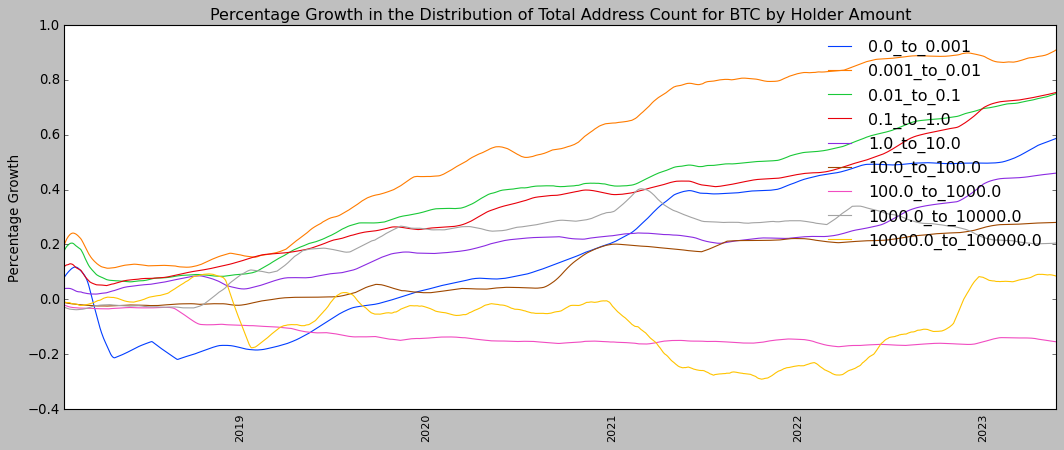

In [34]:
# Prepare address distribution data for plotting
df_distr_add = df_distr.copy()
for i in list(df_distr_add.range.unique()):
    df_distr_add.loc[df_distr.range == i, 'addressesCount_pct_cum'] = df_distr_add[df_distr_add.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
df_distr_add.dropna(inplace=True)
# Lineplot: Address Count by Holder Amount
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df_distr_add, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Percentage Growth in the Distribution of Total Address Count for {BTC} by Holder Amount')
plt.legend(framealpha=0)
plt.show()

In [36]:
new_df_distr = pd.DataFrame({
                          'vol_0.001_to_0.01': df_distr[df_distr.range == '0.001_to_0.01']['totalVolume'].values,
                          'addresses_0.001_to_0.01': df_distr[df_distr.range == '0.001_to_0.01']['addressesCount'].values,
                          'vol_1.0_to_10.0': df_distr[df_distr.range == '1.0_to_10.0']['totalVolume'].values,
                          'addresses_1.0_to_10.0': df_distr[df_distr.range == '1.0_to_10.0']['addressesCount'].values,
                          'vol_100.0_to_1000.0': df_distr[df_distr.range == '100.0_to_1000.0']['totalVolume'].values,
                          'addresses_100.0_to_1000.0': df_distr[df_distr.range == '100.0_to_1000.0']['addressesCount'].values,
                          'vol_1000.0_to_10000.0': df_distr[df_distr.range == '1000.0_to_10000.0']['totalVolume'].values,
                          'addresses_1000.0_to_10000.0': df_distr[df_distr.range == '1000.0_to_10000.0']['addressesCount'].values,
                          'vol_10000.0_to_100000.0': df_distr[df_distr.range == '10000.0_to_100000.0']['totalVolume'].values,
                          'addresses_10000.0_to_100000.0': df_distr[df_distr.range == '10000.0_to_100000.0']['addressesCount'].values})

new_df_distr.index = OHLCV.index
new_df_distr

,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,
2017-12-02,17802.871323,4399165.0,1.425499e+06,531547.0,3.786215e+06,16248.0,3.406775e+06,1578.0,2.755780e+06,112.0
2017-12-03,18000.933308,4429347.0,1.427554e+06,532543.0,3.786568e+06,16250.0,3.399545e+06,1574.0,2.757077e+06,112.0
2017-12-04,18135.635052,4452504.0,1.432802e+06,535314.0,3.784176e+06,16263.0,3.397240e+06,1567.0,2.755907e+06,112.0
2017-12-05,18285.783872,4493651.0,1.437218e+06,537857.0,3.782666e+06,16251.0,3.393080e+06,1562.0,2.751670e+06,112.0
2017-12-06,18510.042473,4541434.0,1.440593e+06,540655.0,3.783064e+06,16230.0,3.387246e+06,1558.0,2.741678e+06,112.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-20,41629.399619,11243236.0,2.105882e+06,844178.0,3.883326e+06,13826.0,4.620023e+06,1924.0,2.313094e+06,110.0
2023-05-21,41530.643148,11215436.0,2.107076e+06,844551.0,3.882159e+06,13828.0,4.622085e+06,1925.0,2.313529e+06,110.0
2023-05-22,41546.290240,11222515.0,2.106359e+06,844387.0,3.886003e+06,13842.0,4.618687e+06,1922.0,2.433526e+06,112.0


In [37]:
new_df_distr = new_df_distr[-len(df_candles_supervised) - 1:-1]
new_df_distr

,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,
2018-06-19,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,112.0
2018-06-20,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,2.921150e+06,112.0
2018-06-21,20348.149665,4967184.0,1.481560e+06,561188.0,3.720305e+06,15776.0,3.380830e+06,1526.0,2.922815e+06,112.0
2018-06-22,20400.538595,4970365.0,1.483107e+06,561787.0,3.716579e+06,15752.0,3.379333e+06,1522.0,2.922891e+06,112.0
2018-06-23,20447.981427,4976527.0,1.484584e+06,562288.0,3.715096e+06,15734.0,3.381790e+06,1524.0,2.922519e+06,112.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-19,41525.801239,11208507.0,2.105677e+06,844140.0,3.883470e+06,13833.0,4.620043e+06,1925.0,2.312975e+06,110.0
2023-05-20,41629.399619,11243236.0,2.105882e+06,844178.0,3.883326e+06,13826.0,4.620023e+06,1924.0,2.313094e+06,110.0
2023-05-21,41530.643148,11215436.0,2.107076e+06,844551.0,3.882159e+06,13828.0,4.622085e+06,1925.0,2.313529e+06,110.0


# Combination_df

In [38]:
combination_df = df_candles_supervised.join(onchain_df, how = 'inner')
combination_df = combination_df.join(new_df_distr, how = 'inner')
combination_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,...,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,...,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,112.0
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,...,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,2.921150e+06,112.0
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,...,20348.149665,4967184.0,1.481560e+06,561188.0,3.720305e+06,15776.0,3.380830e+06,1526.0,2.922815e+06,112.0
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,...,20400.538595,4970365.0,1.483107e+06,561787.0,3.716579e+06,15752.0,3.379333e+06,1522.0,2.922891e+06,112.0
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,...,20447.981427,4976527.0,1.484584e+06,562288.0,3.715096e+06,15734.0,3.381790e+06,1524.0,2.922519e+06,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,22522.74600,24883.933423,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,...,41525.801239,11208507.0,2.105677e+06,844140.0,3.883470e+06,13833.0,4.620043e+06,1925.0,2.312975e+06,110.0
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,...,41629.399619,11243236.0,2.105882e+06,844178.0,3.883326e+06,13826.0,4.620023e+06,1924.0,2.313094e+06,110.0
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,...,41530.643148,11215436.0,2.107076e+06,844551.0,3.882159e+06,13828.0,4.622085e+06,1925.0,2.313529e+06,110.0


In [39]:
combination_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800 entries, 2018-06-19 to 2023-05-23
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   close                            1800 non-null   float64
 1   SMA_200                          1800 non-null   float64
 2   EMA_200                          1800 non-null   float64
 3   SMA_50                           1800 non-null   float64
 4   EMA_50                           1800 non-null   float64
 5   RSI                              1800 non-null   float64
 6   macd                             1800 non-null   float64
 7   signal_line                      1800 non-null   float64
 8   histogram                        1800 non-null   float64
 9   close_diff                       1800 non-null   float64
 10  low_diff                         1800 non-null   float64
 11  open_diff                        1800 non-null   float64
 12  hi

In [40]:
cols = list(combination_df.columns)
a, b = cols.index('direction'), cols.index('addresses_10000.0_to_100000.0')
cols[b], cols[a] = cols[a], cols[b]
combination_df = combination_df[cols]
combination_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,...,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,direction
date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,10183.60025,8952.271138,7921.7492,7597.645760,33.567210,-370.713965,-369.014432,-1.699533,26.46,...,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,0
2018-06-20,6761.27,10162.84295,8927.097160,7875.4290,7564.836147,33.260963,-345.512849,-364.314116,18.801266,19.99,...,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,2.921150e+06,1
2018-06-21,6720.64,10140.21510,8901.784565,7825.1980,7531.720172,31.809048,-325.072057,-356.465704,31.393647,-40.63,...,20348.149665,4967184.0,1.481560e+06,561188.0,3.720305e+06,15776.0,3.380830e+06,1526.0,2.922815e+06,1
2018-06-22,6051.47,10112.35290,8869.135289,7751.3266,7473.653888,26.038914,-358.733740,-356.919311,-1.814429,-669.17,...,20400.538595,4970365.0,1.483107e+06,561787.0,3.716579e+06,15752.0,3.379333e+06,1522.0,2.922891e+06,0
2018-06-23,6166.54,10084.84995,8838.224582,7680.6652,7422.379879,29.526658,-371.839348,-359.903318,-11.936030,115.07,...,20447.981427,4976527.0,1.484584e+06,562288.0,3.715096e+06,15734.0,3.381790e+06,1524.0,2.922519e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,22522.74600,24883.933423,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,...,41525.801239,11208507.0,2.105677e+06,844140.0,3.883470e+06,13833.0,4.620043e+06,1925.0,2.312975e+06,0
2023-05-20,27117.18,22555.93055,24906.154782,28407.5298,27621.490359,26.722530,-421.446762,-358.355494,-63.091268,229.22,...,41629.399619,11243236.0,2.105882e+06,844178.0,3.883326e+06,13826.0,4.620023e+06,1924.0,2.313094e+06,1
2023-05-21,26755.70,22588.95740,24924.558217,28373.3378,27587.537796,26.777328,-431.873885,-373.059172,-58.814713,-361.48,...,41530.643148,11215436.0,2.107076e+06,844551.0,3.882159e+06,13828.0,4.622085e+06,1925.0,2.313529e+06,0


# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [41]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.8
    split_val = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split_val)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.drop(['color_of_candle', 'number_candle_trend', 'direction'], axis =1).columns.values
    # train

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['direction'],axis=1)
    train_X.index = train_X['date']
    train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction'],axis=1)
    test_X.index = test_X['date']
    test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction'],axis=1)
    val_X.index = val_X['date']
    val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [42]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [43]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def metrics(real, forecast):
    
    print('balanced_accuracy:', balanced_accuracy_score(real, forecast))
    print('precision:', precision_score(real, forecast))
    print('recall:', recall_score(real, forecast))
    print('f1-score:', f1_score(real, forecast))
    cm = confusion_matrix(real, forecast)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

VIF

In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = combination_df.drop(['direction'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,1.624805e+03
1,SMA_200,5.770831e+02
2,EMA_200,1.846463e+03
3,SMA_50,2.371041e+03
4,EMA_50,7.705244e+03
5,RSI,2.410727e+00
6,macd,2.170409e+12
7,signal_line,2.476546e+12
8,histogram,5.395148e+11
9,close_diff,2.754066e+07


Выберем признаки со значением меньше 6

In [97]:
columns_vif = ['close']
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 6):
      columns_vif.append(row['Feature Name'])

columns_vif.append('direction')


df_candles_VIF = combination_df[columns_vif]

df_candles_VIF

,close,RSI,low_diff,open_diff,high_diff,color_of_candle,number_candle_trend,transaction_count,average_transaction_value,block_time,block_size,direction
date,,,,,,,,,,,,
2018-06-15,6396.71,29.745768,94.46,333.20,-52.21,1,0,205861.0,8.397615,559.309211,801346.0,0
2018-06-16,6503.10,29.586780,-34.70,-246.92,-98.08,0,0,159090.0,5.157083,516.430303,473838.0,1
2018-06-17,6457.78,27.150891,100.39,106.39,16.62,1,0,144908.0,4.618257,541.403846,490980.0,0
2018-06-18,6714.82,35.931935,-44.97,-45.32,216.26,0,0,196305.0,5.404680,523.803681,648707.0,0
2018-06-19,6741.28,33.567210,270.79,256.78,37.57,0,1,191805.0,7.678289,558.870130,908624.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,27175.06,40.815907,146.35,142.54,466.77,0,1,526379.0,1.365127,580.041096,1751037.0,1
2023-05-16,27036.63,31.534874,115.79,242.97,-366.54,1,0,566462.0,1.560724,562.921053,1714052.0,0
2023-05-17,27404.35,31.862199,-295.66,-138.43,190.42,0,0,583454.0,1.434237,538.622642,1672989.0,1


Epoch 1/20
1147/1147 [==============================] - 22s 16ms/step - loss: 0.7359 - binary_accuracy: 0.5257 - val_loss: 0.8047 - val_binary_accuracy: 0.5053
Epoch 2/20
1147/1147 [==============================] - 18s 15ms/step - loss: 0.7105 - binary_accuracy: 0.5179 - val_loss: 0.6948 - val_binary_accuracy: 0.4982
Epoch 3/20
1147/1147 [==============================] - 18s 15ms/step - loss: 0.7083 - binary_accuracy: 0.5301 - val_loss: 0.6941 - val_binary_accuracy: 0.4982
Epoch 4/20
1147/1147 [==============================] - 19s 17ms/step - loss: 0.7123 - binary_accuracy: 0.5222 - val_loss: 0.6978 - val_binary_accuracy: 0.5194
Epoch 5/20
1147/1147 [==============================] - 17s 15ms/step - loss: 0.7041 - binary_accuracy: 0.5440 - val_loss: 0.6949 - val_binary_accuracy: 0.4912
Epoch 6/20
1147/1147 [==============================] - 16s 14ms/step - loss: 0.7149 - binary_accuracy: 0.5536 - val_loss: 0.7049 - val_binary_accuracy: 0.5053
Epoch 7/20
1147/1147 [==================

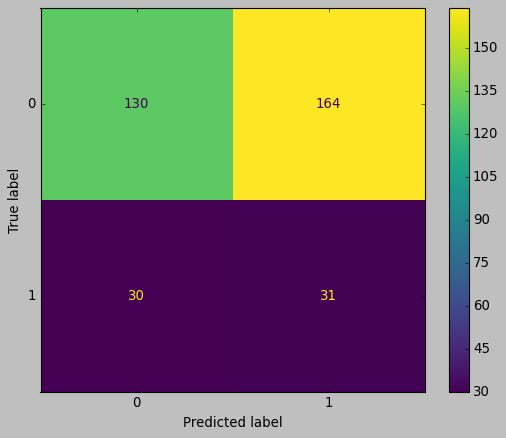

In [106]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)

n_steps = 5
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=1, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)
yhat = yhat.reshape(yhat.shape[0])

for i in range(len(yhat)):
    if (yhat[i]>0.5):
        yhat[i] = 1
    else:
        yhat[i] = 0
        
metrics(yhat, test_y_sq)


RFE

In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['balanced_acc'] = []
Train_yhat_metrics_RFE['precision'] = []
Train_yhat_metrics_RFE['recall'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['balanced_acc'] = []
Test_yhat_metrics_RFE['precision'] = []
Test_yhat_metrics_RFE['recall'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
    model.add(LSTM(56, activation = 'relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=1, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
    yhat_train = yhat_train.reshape(yhat_train.shape[0])
    yhat_test = yhat_test.reshape(yhat_test.shape[0])

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_rfe))
    Train_yhat_metrics_RFE['precision'].append(precision_score(yhat_train, train_y_rfe))
    Train_yhat_metrics_RFE['recall'].append(recall_score(yhat_train, train_y_rfe))


    Test_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_rfe))
    Test_yhat_metrics_RFE['precision'].append(precision_score(yhat_test, test_y_rfe))
    Test_yhat_metrics_RFE['recall'].append(recall_score(yhat_test, test_y_rfe))

    
    


In [160]:
pd.Series(test_y_rfe).value_counts()

1    193
0    157
Name: direction, dtype: int64

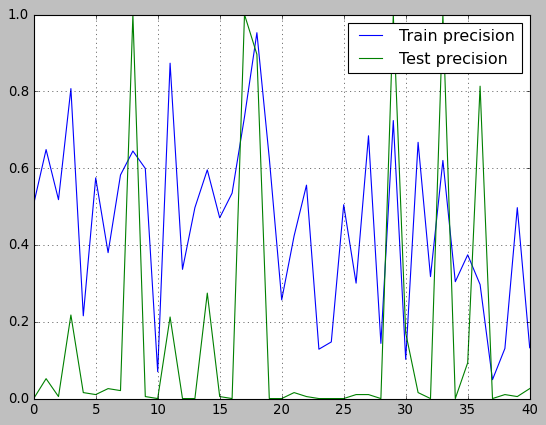

In [161]:
plt.plot(Train_yhat_metrics_RFE['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_RFE['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

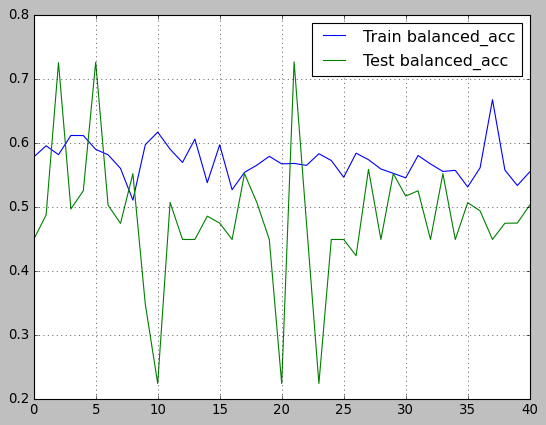

In [162]:
plt.plot(Train_yhat_metrics_RFE['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_RFE['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

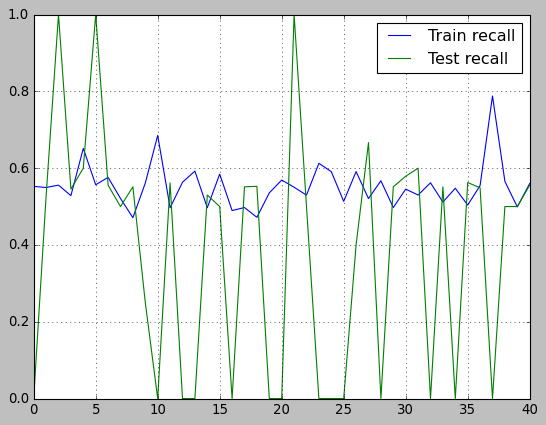

In [163]:
plt.plot(Train_yhat_metrics_RFE['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_RFE['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

Сравнив все показатели самым лучшим показателем будет число 25 для RFE

In [168]:
train_X.loc[:, features_rfe[21]]

,close,SMA_200,EMA_200,SMA_50,macd,close_diff,width_open_close,addresses_10000.0_to_100000.0,zero_balance_addresses_all_time,unique_addresses_all_time,...,block_height,difficulty,current_supply,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,color_of_candle
date,,,,,,,,,,,,,,,,,,,,,
2018-06-16,-0.589753,-0.208941,-0.346980,-0.460707,-0.528817,0.077348,0.077367,0.900571,-1.571458,-1.559158,...,-1.734541,-1.424785,-1.910405,-1.374167,-1.332538,-1.482042,-1.475179,-2.129506,-1.976296,0
2018-06-17,-0.592762,-0.210509,-0.349723,-0.464703,-0.531255,-0.086248,-0.086230,0.997067,-1.570047,-1.557665,...,-1.731310,-1.424785,-1.906548,-1.370388,-1.329253,-1.473653,-1.476101,-2.141863,-1.985812,1
2018-06-18,-0.575696,-0.212009,-0.352159,-0.468422,-0.510672,0.239801,0.239820,0.900571,-1.567968,-1.555611,...,-1.727935,-1.424785,-1.902519,-1.367758,-1.329231,-1.451501,-1.455932,-2.160976,-2.009602,0
2018-06-19,-0.573939,-0.213921,-0.354534,-0.471885,-0.488656,-0.008845,-0.008545,0.900571,-1.565559,-1.553619,...,-1.724746,-1.410192,-1.898712,-1.379085,-1.338099,-1.448886,-1.453071,-2.168388,-2.014360,0
2018-06-20,-0.572612,-0.215848,-0.356858,-0.475084,-0.466229,-0.015821,-0.015803,0.900571,-1.563468,-1.551538,...,-1.721556,-1.400975,-1.894905,-1.368271,-1.331000,-1.457603,-1.463097,-2.168910,-2.028634,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-05,1.693238,2.998105,2.392033,1.394270,1.394985,1.202313,1.202332,-2.090797,1.811223,1.811748,...,1.693475,0.238497,1.390689,1.675943,1.824592,0.546200,0.791431,0.961603,0.569253,0
2021-08-06,1.823637,3.000995,2.395895,1.400858,1.565139,2.080499,2.080517,-2.090797,1.814200,1.814720,...,1.696747,0.238497,1.392998,1.680948,1.833078,0.539941,0.785614,0.954338,0.559737,0
2021-08-07,1.940876,3.005026,2.401344,1.412996,1.804161,1.866749,1.866767,-2.187293,1.816523,1.817199,...,1.700183,0.238497,1.394767,1.687213,1.842789,0.544148,0.788782,0.968423,0.564495,0


Epoch 1/20
1142/1142 [==============================] - 49s 22ms/step - loss: 0.8187 - binary_accuracy: 0.5342 - val_loss: 1.4402 - val_binary_accuracy: 0.5000
Epoch 2/20
1142/1142 [==============================] - 20s 18ms/step - loss: 0.7392 - binary_accuracy: 0.5026 - val_loss: 0.6925 - val_binary_accuracy: 0.5072
Epoch 3/20
1142/1142 [==============================] - 21s 18ms/step - loss: 0.7034 - binary_accuracy: 0.5193 - val_loss: 0.6931 - val_binary_accuracy: 0.4928
Epoch 4/20
1142/1142 [==============================] - 21s 18ms/step - loss: 0.7297 - binary_accuracy: 0.5350 - val_loss: 0.7440 - val_binary_accuracy: 0.5216
Epoch 5/20
1142/1142 [==============================] - 21s 19ms/step - loss: 0.7377 - binary_accuracy: 0.5131 - val_loss: 0.6968 - val_binary_accuracy: 0.5216
Epoch 6/20
1142/1142 [==============================] - 20s 18ms/step - loss: 0.7375 - binary_accuracy: 0.5149 - val_loss: 0.6927 - val_binary_accuracy: 0.5180
Epoch 7/20
11/11 [======================

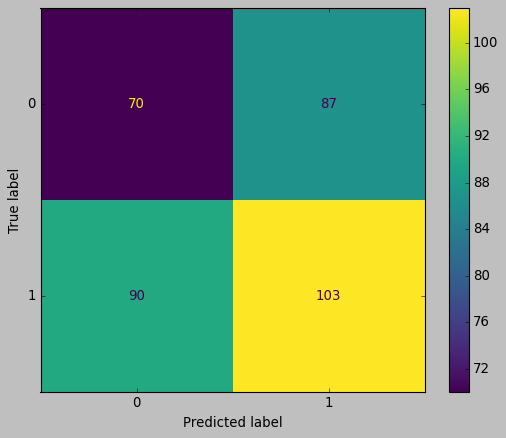

In [46]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)

rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-21)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]


n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=1, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)

yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_rfe, yhat_test)

PCA

In [72]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['balanced_acc'] = []
Train_yhat_metrics_PCA['precision'] = []
Train_yhat_metrics_PCA['recall'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['balanced_acc'] = []
Test_yhat_metrics_PCA['precision'] = []
Test_yhat_metrics_PCA['recall'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 5
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=1, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['precision'].append(precision_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['recall'].append(recall_score(yhat_train, train_y_pca))


    Test_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['precision'].append(precision_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['recall'].append(recall_score(yhat_test, test_y_pca))

Epoch 1/20
1146/1146 [==============================] - 21s 15ms/step - loss: 0.7734 - binary_accuracy: 0.4983 - val_loss: 0.6945 - val_binary_accuracy: 0.4876
Epoch 2/20
1146/1146 [==============================] - 16s 14ms/step - loss: 0.7614 - binary_accuracy: 0.5288 - val_loss: 0.6958 - val_binary_accuracy: 0.5053
Epoch 3/20
1146/1146 [==============================] - 17s 15ms/step - loss: 0.7370 - binary_accuracy: 0.5515 - val_loss: 0.6936 - val_binary_accuracy: 0.5194
Epoch 4/20
1146/1146 [==============================] - 17s 15ms/step - loss: 0.7244 - binary_accuracy: 0.5419 - val_loss: 0.7136 - val_binary_accuracy: 0.4664
Epoch 5/20
1146/1146 [==============================] - 17s 15ms/step - loss: 0.7394 - binary_accuracy: 0.5419 - val_loss: 0.7005 - val_binary_accuracy: 0.5265
Epoch 6/20
1146/1146 [==============================] - 25s 22ms/step - loss: 0.7776 - binary_accuracy: 0.5707 - val_loss: 0.7679 - val_binary_accuracy: 0.4947
Epoch 7/20
1146/1146 [==================

1146/1146 [==============================] - 24s 21ms/step - loss: 0.7843 - binary_accuracy: 0.6326 - val_loss: 0.6885 - val_binary_accuracy: 0.5300
Epoch 10/20
1146/1146 [==============================] - 24s 21ms/step - loss: 0.7668 - binary_accuracy: 0.6588 - val_loss: 0.8202 - val_binary_accuracy: 0.5300
Epoch 11/20
12/12 [==============================] - 0s 23ms/step
Epoch 1/20
1146/1146 [==============================] - 32s 22ms/step - loss: 0.7313 - binary_accuracy: 0.5009 - val_loss: 0.6933 - val_binary_accuracy: 0.5124
Epoch 2/20
1146/1146 [==============================] - 24s 21ms/step - loss: 0.7502 - binary_accuracy: 0.5209 - val_loss: 0.6940 - val_binary_accuracy: 0.4947
Epoch 3/20
1146/1146 [==============================] - 22s 19ms/step - loss: 0.7765 - binary_accuracy: 0.5297 - val_loss: 0.6959 - val_binary_accuracy: 0.5053
Epoch 4/20
12/12 [==============================] - 0s 21ms/step
Epoch 1/20
1146/1146 [==============================] - 33s 23ms/step - loss: 0

Epoch 2/20
1146/1146 [==============================] - 34s 30ms/step - loss: 0.7267 - binary_accuracy: 0.5262 - val_loss: 0.6977 - val_binary_accuracy: 0.5018
Epoch 3/20
1146/1146 [==============================] - 34s 30ms/step - loss: 0.7678 - binary_accuracy: 0.5401 - val_loss: 0.6953 - val_binary_accuracy: 0.5194
Epoch 4/20
1146/1146 [==============================] - 32s 28ms/step - loss: 0.7255 - binary_accuracy: 0.5262 - val_loss: 0.6922 - val_binary_accuracy: 0.5265
Epoch 5/20
1146/1146 [==============================] - 25s 22ms/step - loss: 0.7204 - binary_accuracy: 0.5620 - val_loss: 0.6981 - val_binary_accuracy: 0.4947
Epoch 6/20
1146/1146 [==============================] - 36s 31ms/step - loss: 0.7293 - binary_accuracy: 0.5497 - val_loss: 0.6975 - val_binary_accuracy: 0.4982
Epoch 7/20
12/12 [==============================] - 0s 32ms/step
Epoch 1/20
1146/1146 [==============================] - 52s 32ms/step - loss: 0.7392 - binary_accuracy: 0.5227 - val_loss: 0.6930 - val

Epoch 5/20
1146/1146 [==============================] - 22s 19ms/step - loss: 0.7147 - binary_accuracy: 0.5375 - val_loss: 0.7000 - val_binary_accuracy: 0.4876
Epoch 6/20
12/12 [==============================] - 0s 23ms/step
Epoch 1/20
1146/1146 [==============================] - 29s 20ms/step - loss: 0.8528 - binary_accuracy: 0.5314 - val_loss: 0.7116 - val_binary_accuracy: 0.5159
Epoch 2/20
1146/1146 [==============================] - 22s 19ms/step - loss: 0.7284 - binary_accuracy: 0.5017 - val_loss: 0.6989 - val_binary_accuracy: 0.4982
Epoch 3/20
1146/1146 [==============================] - 22s 19ms/step - loss: 0.7137 - binary_accuracy: 0.5340 - val_loss: 0.6968 - val_binary_accuracy: 0.4770
Epoch 4/20
12/12 [==============================] - 0s 19ms/step
Epoch 1/20
1146/1146 [==============================] - 30s 21ms/step - loss: 0.7681 - binary_accuracy: 0.5305 - val_loss: 0.7010 - val_binary_accuracy: 0.4806
Epoch 2/20
1146/1146 [==============================] - 23s 20ms/step 

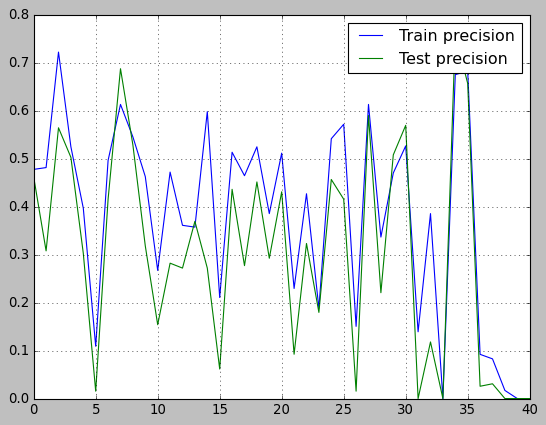

In [73]:
plt.plot(Train_yhat_metrics_PCA['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_PCA['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

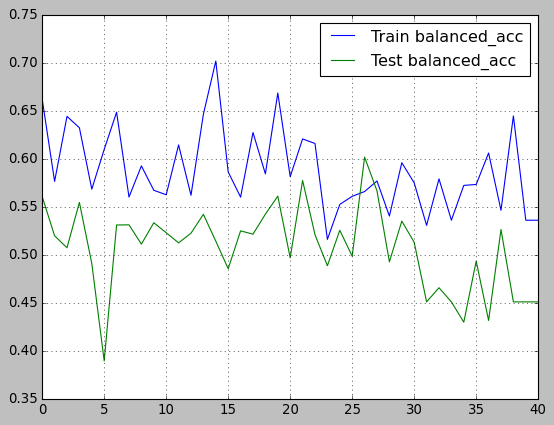

In [148]:
plt.plot(Train_yhat_metrics_PCA['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_PCA['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

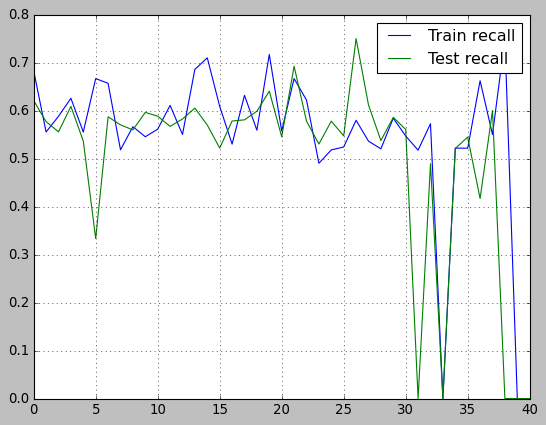

In [75]:
plt.plot(Train_yhat_metrics_PCA['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_PCA['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

Для PCA наиболее оптимальным показателем стал 26


Epoch 1/20
16/16 [==============================] - 13s 273ms/step - loss: 0.7027 - binary_accuracy: 0.5241 - val_loss: 0.6938 - val_binary_accuracy: 0.4820
Epoch 2/20
16/16 [==============================] - 3s 185ms/step - loss: 0.6901 - binary_accuracy: 0.5372 - val_loss: 0.6930 - val_binary_accuracy: 0.5144
Epoch 3/20
16/16 [==============================] - 3s 178ms/step - loss: 0.6886 - binary_accuracy: 0.5486 - val_loss: 0.6962 - val_binary_accuracy: 0.4928
Epoch 4/20
16/16 [==============================] - 3s 188ms/step - loss: 0.6896 - binary_accuracy: 0.5425 - val_loss: 0.6939 - val_binary_accuracy: 0.4964
Epoch 5/20
11/11 [==============================] - 0s 37ms/step
balanced_accuracy: 0.5138609286822218
precision: 0.5857142857142857
recall: 0.21243523316062177
f1-score: 0.311787072243346


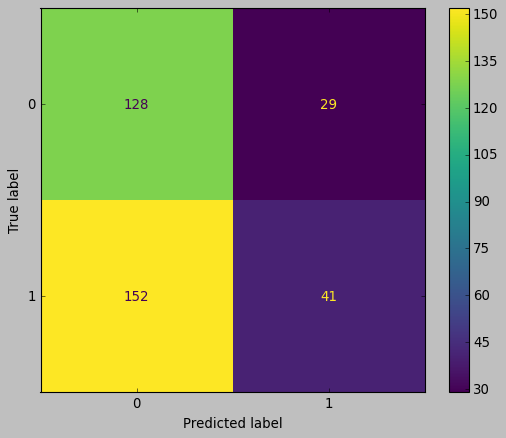

In [78]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)


pca = PCA(n_components=train_X.shape[1]-26)           

Train_X_std_pca = pca.fit_transform(train_X)
Val_X_std_pca = pca.fit_transform(val_X)
Test_X_std_pca = pca.fit_transform(test_X)


Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
Val_X_std_pca = pd.DataFrame(Val_X_std_pca)

n_steps = 10
Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)


train_y_pca = train_y[n_steps - 1: -1]
val_y_pca = val_y[n_steps - 1: -1]
test_y_pca = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)
yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_pca, yhat_test)

RFE показала себя лучше

# Quantity of candles Selection

In [47]:
train_X.loc[:, rfe.support_]

,close,EMA_200,macd,close_diff,width_open_close,addresses_10000.0_to_100000.0,zero_balance_addresses_all_time,unique_addresses_all_time,transaction_count_all_time,block_height,...,current_supply,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,color_of_candle
date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,-0.578912,-0.360861,-0.493892,-0.009895,-0.009597,0.904980,-1.572679,-1.560652,-1.637649,-1.733973,...,-1.911987,-1.385789,-1.343845,-1.458620,-1.462833,0.539671,2.989415,-2.188076,-2.031820,0
2018-06-20,-0.577593,-0.363167,-0.471651,-0.016829,-0.016810,0.904980,-1.570593,-1.558576,-1.635719,-1.730786,...,-1.908173,-1.374996,-1.336768,-1.467361,-1.472880,0.555621,3.031651,-2.188600,-2.046167,0
2018-06-21,-0.580274,-0.365486,-0.453612,-0.081794,-0.081776,0.904980,-1.568635,-1.556551,-1.633796,-1.727290,...,-1.903989,-1.369517,-1.332298,-1.457992,-1.469705,0.601628,3.075898,-2.197397,-2.050949,1
2018-06-22,-0.624431,-0.368476,-0.483319,-0.755395,-0.755376,0.904980,-1.566552,-1.554503,-1.631815,-1.724185,...,-1.900274,-1.359905,-1.330203,-1.442559,-1.455511,0.574435,3.027629,-2.199857,-2.070079,1
2018-06-23,-0.616838,-0.371308,-0.494885,0.085068,0.085086,0.904980,-1.564986,-1.552811,-1.630230,-1.720894,...,-1.896336,-1.351200,-1.326144,-1.427813,-1.443640,0.563605,2.991426,-2.195821,-2.060514,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09,2.030964,2.380793,2.122373,2.603318,2.603335,-2.165539,1.808014,1.808014,1.644546,1.694895,...,1.391165,1.649432,1.798980,0.549797,0.786932,2.086007,-0.823896,0.947955,0.608002,0
2021-08-10,1.985328,2.386918,2.231439,-0.779412,-0.779393,-2.261493,1.810981,1.810965,1.647079,1.698288,...,1.393195,1.656524,1.807361,0.542942,0.785155,2.094303,-0.827919,0.972441,0.593655,1
2021-08-11,1.982402,2.392943,2.286438,-0.085770,-0.085752,-1.973632,1.813702,1.813925,1.649626,1.701311,...,1.395029,1.662513,1.816978,0.549241,0.789799,2.086170,-0.817862,0.917064,0.550615,1


In [48]:
columns = list(train_X.loc[:, rfe.support_].columns.values)
columns.append('direction')
df = combination_df.loc[:,columns]
df

,close,EMA_200,macd,close_diff,width_open_close,addresses_10000.0_to_100000.0,zero_balance_addresses_all_time,unique_addresses_all_time,transaction_count_all_time,block_height,...,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,color_of_candle,direction
date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,6741.28,8952.271138,-370.713965,26.46,26.72,112.0,3.868683e+08,4.094810e+08,323339844.0,528286.0,...,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,0,0
2018-06-20,6761.27,8927.097160,-345.512849,19.99,19.99,112.0,3.871478e+08,4.097698e+08,323538733.0,528441.0,...,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,0,1
2018-06-21,6720.64,8901.784565,-325.072057,-40.63,-40.63,112.0,3.874102e+08,4.100515e+08,323736846.0,528611.0,...,20348.149665,4967184.0,1.481560e+06,561188.0,3.720305e+06,15776.0,3.380830e+06,1526.0,1,1
2018-06-22,6051.47,8869.135289,-358.733740,-669.17,-669.17,112.0,3.876892e+08,4.103364e+08,323940990.0,528762.0,...,20400.538595,4970365.0,1.483107e+06,561787.0,3.716579e+06,15752.0,3.379333e+06,1522.0,1,0
2018-06-23,6166.54,8838.224582,-371.839348,115.07,115.07,112.0,3.878991e+08,4.105716e+08,324104285.0,528922.0,...,20447.981427,4976527.0,1.484584e+06,562288.0,3.715096e+06,15734.0,3.381790e+06,1524.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,26887.96,24883.933423,-438.813063,66.11,66.11,110.0,1.104947e+09,1.151502e+09,840647225.0,790529.0,...,41525.801239,11208507.0,2.105677e+06,844140.0,3.883470e+06,13833.0,4.620043e+06,1925.0,0,0
2023-05-20,27117.18,24906.154782,-421.446762,229.22,229.22,110.0,1.105241e+09,1.151864e+09,841070961.0,790660.0,...,41629.399619,11243236.0,2.105882e+06,844178.0,3.883326e+06,13826.0,4.620023e+06,1924.0,0,1
2023-05-21,26755.70,24924.558217,-431.873885,-361.48,-361.48,110.0,1.105602e+09,1.152219e+09,841557586.0,790811.0,...,41530.643148,11215436.0,2.107076e+06,844551.0,3.882159e+06,13828.0,4.622085e+06,1925.0,1,0


In [52]:
For_Comparing_candles = pd.DataFrame(np.zeros([4,4]), columns=['precision','recall','accuracy','f1'])

def Evaluate_candles(n, real,forecast):
    For_Comparing_candles.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_candles.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_candles.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_candles.loc[n,'f1']  = round(f1_score(real, forecast),20)

In [53]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu', 'tanh'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model

In [54]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = list(dataset.columns.values)
    features.remove('direction')

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    train_categorial = train.loc[:,['direction']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    test_categorial = test.loc[:,['direction']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)
    
    
    val_categorial = val.loc[:,['direction']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['direction'],axis=1)
    train_X.index = train_X['date']
    train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction'],axis=1)
    test_X.index = test_X['date']
    test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction'],axis=1)
    val_X.index = val_X['date']
    val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

3 свечи

Epoch 1/20
1149/1149 [==============================] - 31s 7ms/step - loss: 0.7085 - binary_accuracy: 0.5152 - val_loss: 0.7028 - val_binary_accuracy: 0.4982
Epoch 2/20
1149/1149 [==============================] - 6s 5ms/step - loss: 0.7083 - binary_accuracy: 0.5117 - val_loss: 0.6964 - val_binary_accuracy: 0.4947
Epoch 3/20
1149/1149 [==============================] - 9s 7ms/step - loss: 0.7141 - binary_accuracy: 0.5248 - val_loss: 0.6898 - val_binary_accuracy: 0.5404
Epoch 4/20
1149/1149 [==============================] - 12s 10ms/step - loss: 0.7100 - binary_accuracy: 0.5379 - val_loss: 0.6993 - val_binary_accuracy: 0.5018
Epoch 5/20
1149/1149 [==============================] - 12s 10ms/step - loss: 0.7074 - binary_accuracy: 0.5448 - val_loss: 0.7177 - val_binary_accuracy: 0.5333
Epoch 6/20
12/12 [==============================] - 3s 10ms/step
balanced_accuracy: 0.5273957409050577
precision: 0.5736040609137056
recall: 0.576530612244898
f1-score: 0.5750636132315523


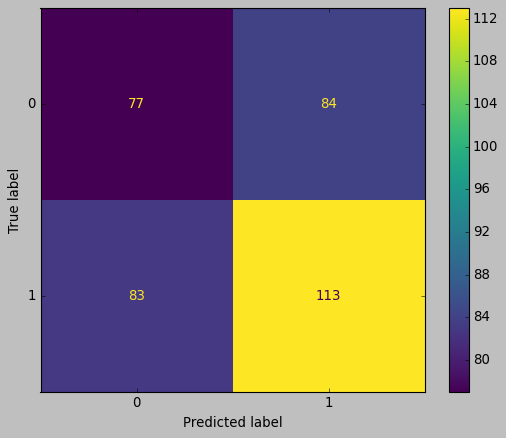

In [57]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_3 = model.predict(test_X)
yhat_test_3 = yhat_test_3.reshape(yhat_test_3.shape[0])

for i in range(len(yhat_test_3)):
    if (yhat_test_3[i]>0.5):
        yhat_test_3[i] = 1
    else:
        yhat_test_3[i] = 0


metrics(test_y, yhat_test_3)

In [58]:
Evaluate_candles(0, test_y, yhat_test_3)

5 свечей

Epoch 1/20
1147/1147 [==============================] - 34s 15ms/step - loss: 0.7086 - binary_accuracy: 0.5031 - val_loss: 0.6946 - val_binary_accuracy: 0.5018
Epoch 2/20
1147/1147 [==============================] - 14s 12ms/step - loss: 0.7115 - binary_accuracy: 0.5222 - val_loss: 0.7014 - val_binary_accuracy: 0.4912
Epoch 3/20
1147/1147 [==============================] - 14s 12ms/step - loss: 0.7270 - binary_accuracy: 0.5371 - val_loss: 0.6934 - val_binary_accuracy: 0.5159
Epoch 4/20
1147/1147 [==============================] - 14s 12ms/step - loss: 0.7438 - binary_accuracy: 0.5458 - val_loss: 0.6920 - val_binary_accuracy: 0.5159
Epoch 5/20
1147/1147 [==============================] - 14s 12ms/step - loss: 0.7204 - binary_accuracy: 0.5562 - val_loss: 0.7200 - val_binary_accuracy: 0.4982
Epoch 6/20
12/12 [==============================] - 1s 5ms/step
balanced_accuracy: 0.505849358974359
precision: 0.575
recall: 0.11794871794871795
f1-score: 0.1957446808510638


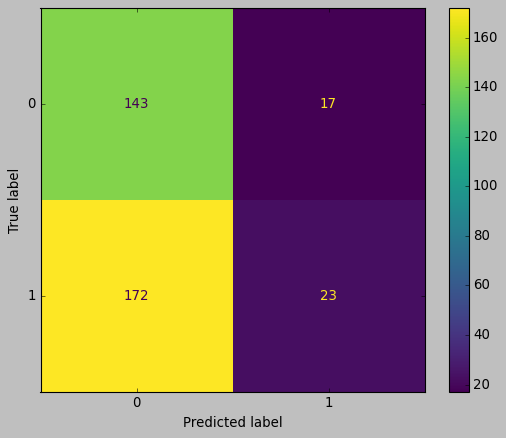

In [59]:


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history


yhat_test_5 = model.predict(test_X)
yhat_test_5 = yhat_test_5.reshape(yhat_test_5.shape[0])

for i in range(len(yhat_test_5)):
    if (yhat_test_5[i]>0.5):
        yhat_test_5[i] = 1
    else:
        yhat_test_5[i] = 0


metrics(test_y, yhat_test_5)

In [60]:
Evaluate_candles(1, test_y, yhat_test_5)

10 свечей

Epoch 1/20
1142/1142 [==============================] - 12s 8ms/step - loss: 0.8046 - binary_accuracy: 0.4939 - val_loss: 0.6932 - val_binary_accuracy: 0.4928
Epoch 2/20
1142/1142 [==============================] - 9s 8ms/step - loss: 0.7104 - binary_accuracy: 0.5236 - val_loss: 0.6935 - val_binary_accuracy: 0.5000
Epoch 3/20
1142/1142 [==============================] - 19s 16ms/step - loss: 0.7111 - binary_accuracy: 0.5315 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/20
1142/1142 [==============================] - 19s 17ms/step - loss: 0.7146 - binary_accuracy: 0.5271 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 5/20
11/11 [==============================] - 3s 18ms/step
balanced_accuracy: 0.5084155638427774
precision: 0.6
recall: 0.09326424870466321
f1-score: 0.16143497757847533


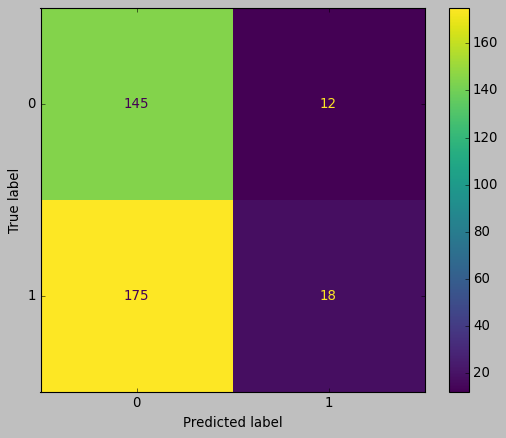

In [61]:

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_10 = model.predict(test_X)
yhat_test_10 = yhat_test_10.reshape(yhat_test_10.shape[0])

for i in range(len(yhat_test_10)):
    if (yhat_test_10[i]>0.5):
        yhat_test_10[i] = 1
    else:
        yhat_test_10[i] = 0


metrics(test_y, yhat_test_10)

In [62]:
Evaluate_candles(2, test_y, yhat_test_10)

20 свечей

Epoch 1/20
1132/1132 [==============================] - 41s 26ms/step - loss: 0.8362 - binary_accuracy: 0.5212 - val_loss: 0.6971 - val_binary_accuracy: 0.4888
Epoch 2/20
1132/1132 [==============================] - 28s 25ms/step - loss: 0.8649 - binary_accuracy: 0.5398 - val_loss: 1.5347 - val_binary_accuracy: 0.5000
Epoch 3/20
1132/1132 [==============================] - 28s 25ms/step - loss: 0.7376 - binary_accuracy: 0.5203 - val_loss: 0.7012 - val_binary_accuracy: 0.5000
Epoch 4/20
1132/1132 [==============================] - 27s 24ms/step - loss: 0.7914 - binary_accuracy: 0.5230 - val_loss: 0.7031 - val_binary_accuracy: 0.5000
Epoch 5/20
11/11 [==============================] - 4s 33ms/step
balanced_accuracy: 0.4967741935483871
precision: 0.0
recall: 0.0
f1-score: 0.0


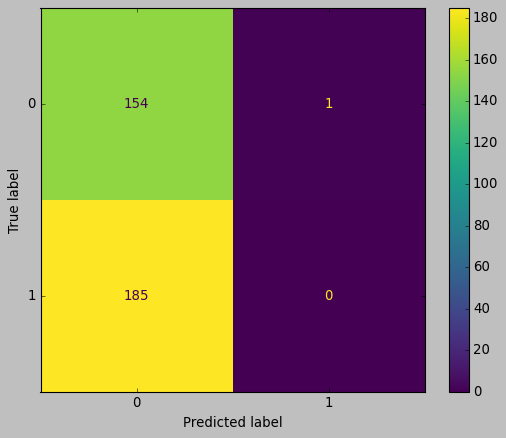

In [63]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history


yhat_test_20 = model.predict(test_X)
yhat_test_20 = yhat_test_20.reshape(yhat_test_20.shape[0])

for i in range(len(yhat_test_20)):
    if (yhat_test_20[i]>0.5):
        yhat_test_20[i] = 1
    else:
        yhat_test_20[i] = 0


metrics(test_y, yhat_test_20)

In [64]:
Evaluate_candles(3, test_y, yhat_test_20)

In [65]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10','20']
Table_of_Comapring_candles

,precision,recall,accuracy,f1
3,0.573604,0.576531,0.527396,0.575064
5,0.575000,0.117949,0.505849,0.195745
10,0.600000,0.093264,0.508416,0.161435
20,0.000000,0.000000,0.496774,0.000000


# NN selection

Выбор наилучшего архитектуры

In [66]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,4]), columns=['precision','recall','accuracy','f1'])

def Evaluate_NN(n, real,forecast):
    For_Comparing_NN.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_NN.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_NN.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_NN.loc[n,'f1']  = round(f1_score(real, forecast),20)
                                

In [74]:
n_steps = 3

LSTM

Trial 5 Complete [00h 03m 00s]
val_binary_accuracy: 0.519298255443573

Best val_binary_accuracy So Far: 0.5719298124313354
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 1s 14ms/step
balanced_accuracy: 0.5
precision: 0.0
recall: 0.0
f1-score: 0.0


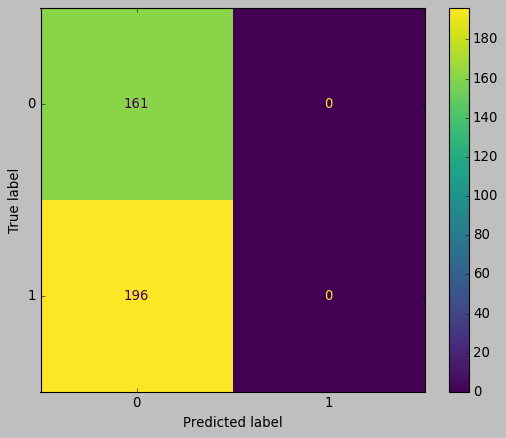

In [102]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=64,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice))
#     for i in range(hyperparams.Int('num_layers', min_value=5, max_value=5)):
#         model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                        min_value=256,   
#                                        max_value=512,   
#                                        step=8),
#                           activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=256,   
#                                    max_value=512,   
#                                    step=8),
#                     activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1DLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_LSTM = best_model_.predict(test_X)
yhat_test_LSTM = yhat_test_LSTM.reshape(yhat_test_LSTM.shape[0])

for i in range(len(yhat_test_LSTM)):
    if (yhat_test_LSTM[i]>0.5):
        yhat_test_LSTM[i] = 1
    else:
        yhat_test_LSTM[i] = 0


metrics(test_y, yhat_test_LSTM)

In [ ]:
Evaluate_NN(0, test_y, yhat_test_LSTM)

GRU

Trial 10 Complete [00h 01m 08s]
val_binary_accuracy: 0.557894766330719

Best val_binary_accuracy So Far: 0.5614035129547119
Total elapsed time: 00h 20m 31s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 1s 14ms/step
balanced_accuracy: 0.5208518189884649
precision: 0.6486486486486487
recall: 0.12244897959183673
f1-score: 0.2060085836909871


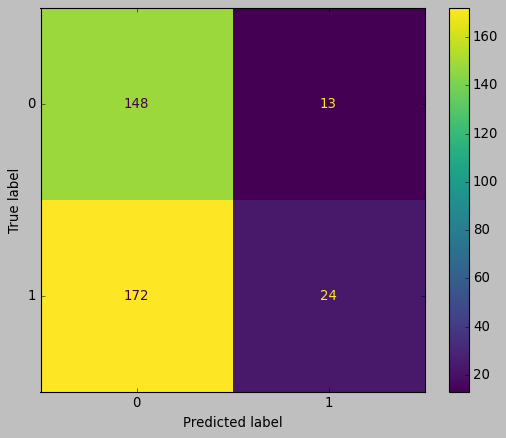

In [103]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=64,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice))
#     for i in range(hyperparams.Int('num_layers', min_value=5, max_value=5)):
#         model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                        min_value=256,   
#                                        max_value=512,   
#                                        step=8),
#                           activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=256,   
#                                    max_value=512,   
#                                    step=8),
#                     activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_GRU = best_model_.predict(test_X)
yhat_test_GRU = yhat_test_GRU.reshape(yhat_test_GRU.shape[0])

for i in range(len(yhat_test_GRU)):
    if (yhat_test_GRU[i]>0.5):
        yhat_test_GRU[i] = 1
    else:
        yhat_test_GRU[i] = 0


metrics(test_y, yhat_test_GRU)

In [72]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 376)            598592    
                                                                 
 lstm_1 (LSTM)               (None, 104)               200096    
                                                                 
 dense (Dense)               (None, 1)                 105       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 798,793
Trainable params: 798,793
Non-trainable params: 0
_________________________________________________________________


In [73]:
Evaluate_NN(1, test_y, yhat_test_GRU)

BiLSTM

Trial 10 Complete [00h 02m 10s]
val_binary_accuracy: 0.5614035129547119

Best val_binary_accuracy So Far: 0.5684210658073425
Total elapsed time: 00h 09m 24s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 0s 5ms/step
balanced_accuracy: 0.5024401064773736
precision: 0.5542168674698795
recall: 0.23469387755102042
f1-score: 0.3297491039426524


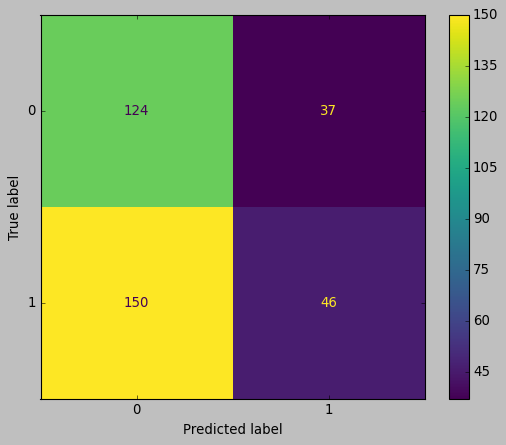

In [105]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=64,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice)))
#     for i in range(hyperparams.Int('num_layers', min_value=5, max_value=5)):
#         model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                        min_value=256,   
#                                        max_value=512,   
#                                        step=8),
#                           activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=256,   
#                                    max_value=512,   
#                                    step=8),
#                     activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DBiLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiLSTM = best_model_.predict(test_X)
yhat_test_BiLSTM = yhat_test_BiLSTM.reshape(yhat_test_BiLSTM.shape[0])

for i in range(len(yhat_test_BiLSTM)):
    if (yhat_test_BiLSTM[i]>0.5):
        yhat_test_BiLSTM[i] = 1
    else:
        yhat_test_BiLSTM[i] = 0


metrics(test_y, yhat_test_BiLSTM)

In [106]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               177600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 177,801
Trainable params: 177,801
Non-trainable params: 0
_________________________________________________________________


In [77]:
Evaluate_NN(2, test_y, yhat_test_BiLSTM)

BiGRU

Trial 10 Complete [00h 02m 13s]
val_binary_accuracy: 0.5122807025909424

Best val_binary_accuracy So Far: 0.5789473652839661
Total elapsed time: 00h 12m 53s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 0s 8ms/step
balanced_accuracy: 0.495452528837622
precision: 0.5319148936170213
recall: 0.12755102040816327
f1-score: 0.20576131687242802


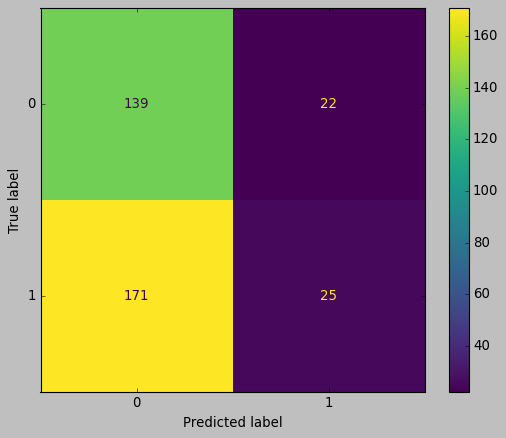

In [107]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                  min_value=64,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice)))
#     for i in range(hyperparams.Int('num_layers', min_value=5, max_value=5)):
#         model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                        min_value=256,   
#                                        max_value=512,   
#                                        step=8),
#                           activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=256,   
#                                    max_value=512,   
#                                    step=8),
#                     activation=activation_choice))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DBiGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiGRU = best_model_.predict(test_X)
yhat_test_BiGRU = yhat_test_BiGRU.reshape(yhat_test_BiGRU.shape[0])

for i in range(len(yhat_test_BiGRU)):
    if (yhat_test_BiGRU[i]>0.5):
        yhat_test_BiGRU[i] = 1
    else:
        yhat_test_BiGRU[i] = 0


metrics(test_y, yhat_test_BiGRU)

In [79]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 432)            784512    
                                                                 
 lstm_1 (LSTM)               (None, 3, 168)            403872    
                                                                 
 lstm_2 (LSTM)               (None, 64)                59648     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,248,097
Trainable params: 1,248,097
Non-trainable params: 0
_________________________________________________________________


In [80]:
Evaluate_NN(3, test_y, yhat_test_BiGRU)

Conv-LSTM

Trial 3 Complete [00h 00m 27s]
val_binary_accuracy: 0.5298245549201965

Best val_binary_accuracy So Far: 0.557894766330719
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 0s 2ms/step
balanced_accuracy: 0.5025510204081632
precision: 1.0
recall: 0.00510204081632653
f1-score: 0.01015228426395939


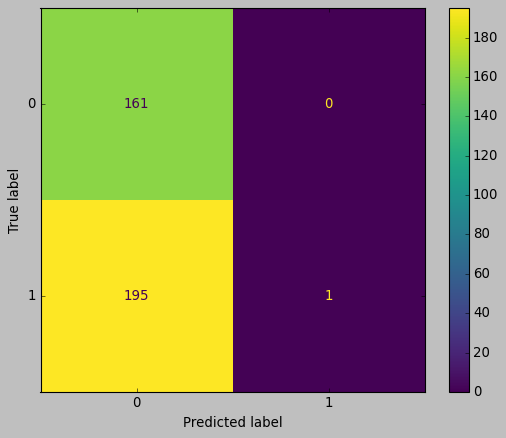

In [108]:
def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=3,
                      #seed=123,
                      project_name="BTC1DCONVLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_CONVLSTM = best_model_.predict(test_X)
yhat_test_CONVLSTM = yhat_test_CONVLSTM.reshape(yhat_test_CONVLSTM.shape[0])

for i in range(len(yhat_test_CONVLSTM)):
    if (yhat_test_CONVLSTM[i]>0.5):
        yhat_test_CONVLSTM[i] = 1
    else:
        yhat_test_CONVLSTM[i] = 0


metrics(test_y, yhat_test_CONVLSTM)

In [85]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 32)          34048     
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 34,145
Trainable params: 34,145
Non-trainable params: 0
_________________________________________________________________


In [86]:
Evaluate_NN(4, test_y, yhat_test_CONVLSTM)

In [109]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,precision,recall,accuracy,f1
LSTM,0.000000,0.000000,0.500000,0.000000
GRU,0.000000,0.000000,0.500000,0.000000
BiLSTM,0.500000,0.005102,0.499445,0.010101
BiGRU,0.000000,0.000000,0.500000,0.000000
CONV-LSTM,0.615385,0.081633,0.509760,0.144144


Лучше всего себя показали CONV-LSTM сеть